# Does age influence who you see as a software engineer?

Introduction goes here

In [84]:
# imports
import pandas as pd
import numpy
from scipy import stats

In [85]:
# grab all the data we need from the db
from sqlalchemy import create_engine
engine = create_engine('sqlite:////Users/rachel/projects/eng_survey_raw/results.db')
with engine.connect() as conn, conn.begin():
    eng_traits_data = pd.read_sql_table('q1_competent_software_engineer_traits', conn)
    demographics_data = pd.read_sql_table('q31q36_demographics', conn)
    setup_questions_data = pd.read_sql_table('q3q6_setup_questions', conn)

In [86]:
# plots n graphs setup shenanigans
%matplotlib inline

import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
plt.rcParams['figure.figsize'] = (15, 20)
plt.rcParams['font.family'] = 'sans-serif'

In [87]:
# constants
age_17_or_younger = "17 or younger"
age_18_to_24 = "18 to 24"
age_25_to_34 = "25 to 34"
age_35_to_44 = "35 to 44"
age_45_to_54 = "45 to 54"
age_55_to_64 = "55 to 64"

UNDER_TWENTY_FIVE_VALUES = [age_18_to_24]
OVER_TWENTY_FIVE_VALUES = [age_25_to_34, age_35_to_44, age_45_to_54, age_55_to_64]

UNDER_THIRTY_FIVE_VALUES = [age_18_to_24, age_25_to_34]
OVER_THIRTY_FIVE_VALUES = [age_35_to_44, age_45_to_54, age_55_to_64]

OVER_TWENTY_FIVE = "Yes"
UNDER_TWENTY_FIVE = "No"

OVER_THIRTY_FIVE = "Yes"
UNDER_THIRTY_FIVE = "No"

# How do different age groups see software engineering differently?

An interesting way to slice this data is by people who have CS degrees vs. people who do not. 


In [88]:
# this gets a list of engineering traits so we can pivot on them later
excluded_trait_columns = ('id', 'response_id', 'something_else_writein1', 'something_else_writein2')
eng_traits = [trait for trait in list(eng_traits_data.columns.values) if trait not in excluded_trait_columns]

In [89]:
# Smoosh the right bits of data together. In this case, we want 1) eng traits 
# 2) split out by CS degree 3) by people who identify themselves as engineers 

age_traits_data = pd.merge(eng_traits_data, 
                           demographics_data[["response_id", "age"]], 
                           on="response_id", 
                           how="inner",
                           sort=False)
only_software_engineers = setup_questions_data.query("are_you_a_software_engineer == True")

age_traits_engineers_only_data = pd.merge(age_traits_data, only_software_engineers[["response_id"]], on="response_id", how="inner", sort=False)

In [90]:
# I asked this question in a dumb way, and what I want to do is aggregate into groups (over/under 25, over/under 35)
# There's probably a smarter way to do this

def over_twenty_five(age):
    return 'No' if age in UNDER_TWENTY_FIVE_VALUES else 'Yes'
    
def over_thirty_five(age):
    return 'No' if age in UNDER_THIRTY_FIVE_VALUES else 'Yes'


age_traits_engineers_only_data['over_25'] = age_traits_engineers_only_data["age"].apply(over_twenty_five)
age_traits_engineers_only_data['over_35'] = age_traits_engineers_only_data["age"].apply(over_thirty_five)


In [91]:
age_25_traits_data = pd.pivot_table(age_traits_engineers_only_data, index=["over_25"], values=eng_traits)
age_35_traits_data = pd.pivot_table(age_traits_engineers_only_data, index=["over_35"], values=eng_traits)

## What does each group value the highest?

In [92]:
age_25_traits_data.stack()[OVER_TWENTY_FIVE].sort_values(ascending=False)[:10]

logically_work_through_problem     0.942664
write_code_for_others              0.932546
reason_about_other_peoples_code    0.903879
can_admit_mistakes                 0.870152
teamwork                           0.851602
shipping_code                      0.809444
curiousity                         0.806071
can_make_tradeoffs                 0.801012
empathy                            0.795953
language_features_knowledge        0.728499
dtype: float64

In [93]:
age_25_traits_data.stack()[UNDER_TWENTY_FIVE].sort_values(ascending=False)[:10]

write_code_for_others              0.936508
logically_work_through_problem     0.936508
reason_about_other_peoples_code    0.920635
can_admit_mistakes                 0.904762
teamwork                           0.888889
curiousity                         0.841270
empathy                            0.777778
code_structure_skills              0.761905
data_structures                    0.761905
design_and_architecture_skills     0.761905
dtype: float64

In [94]:
age_35_traits_data.stack()[OVER_THIRTY_FIVE].sort_values(ascending=False)[:10]

logically_work_through_problem     0.946058
write_code_for_others              0.917012
can_admit_mistakes                 0.896266
reason_about_other_peoples_code    0.887967
teamwork                           0.846473
can_make_tradeoffs                 0.834025
curiousity                         0.821577
shipping_code                      0.792531
empathy                            0.767635
language_features_knowledge        0.751037
dtype: float64

In [95]:
age_35_traits_data.stack()[UNDER_THIRTY_FIVE].sort_values(ascending=False)[:10]

write_code_for_others              0.942169
logically_work_through_problem     0.939759
reason_about_other_peoples_code    0.915663
teamwork                           0.860241
can_admit_mistakes                 0.860241
shipping_code                      0.809639
empathy                            0.809639
curiousity                         0.802410
can_make_tradeoffs                 0.771084
design_and_architecture_skills     0.734940
dtype: float64

## What do various age ranges value differently?

The next interesting question is: are there traits each group values more than the other? 


In [99]:
traits_by_age_35 = age_35_traits_data.transpose()

traits_by_age_35['Difference'] = (traits_by_age_35[OVER_THIRTY_FIVE] - traits_by_age_35[UNDER_THIRTY_FIVE])
traits_by_age_35.applymap(lambda x: '%.1f%%' % (x * 100))


over_35,No,Yes,Difference
adapability,61.7%,59.8%,-1.9%
advanced_algorithms,16.9%,11.2%,-5.7%
can_act_in_crisis,39.3%,32.0%,-7.3%
can_admit_mistakes,86.0%,89.6%,3.6%
can_handle_disruptions_or_interruptions,28.0%,27.0%,-1.0%
can_learn_quickly,68.7%,60.6%,-8.1%
can_make_tradeoffs,77.1%,83.4%,6.3%
code_structure_skills,72.3%,68.5%,-3.8%
concurrency,57.1%,55.2%,-1.9%
curiousity,80.2%,82.2%,1.9%


In [114]:
traits_difference_35 = traits_by_age_35.apply(lambda row: (row[OVER_THIRTY_FIVE] - row[UNDER_THIRTY_FIVE]) * 100,axis=1)


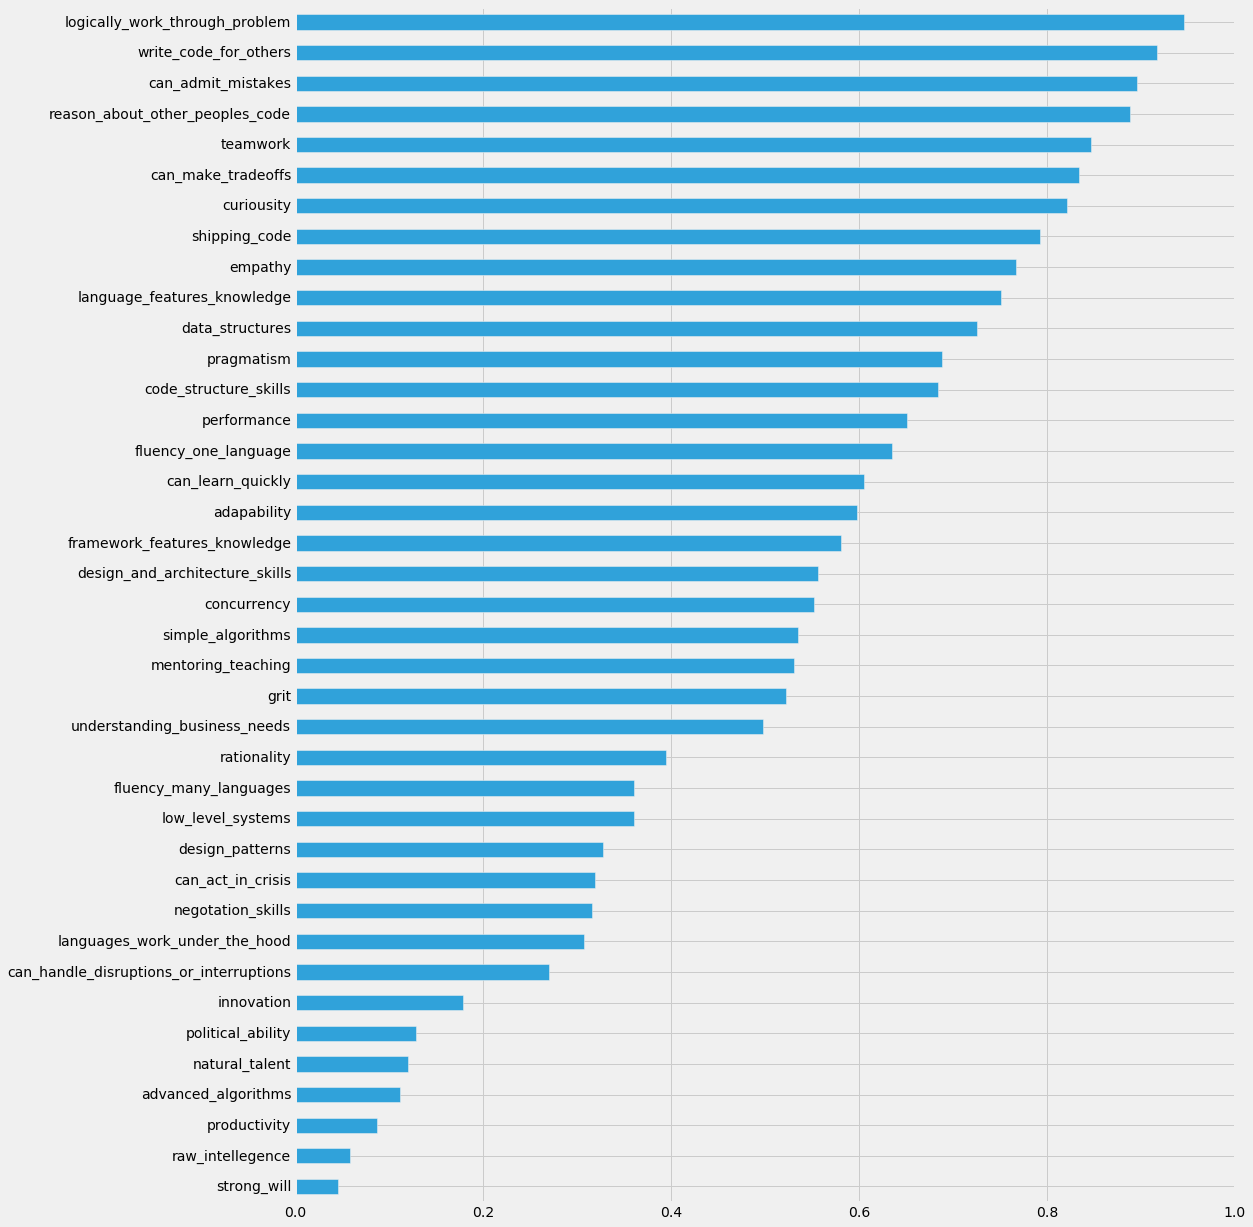

In [106]:
trait_plot2 = age_35_traits_data.stack()[OVER_THIRTY_FIVE].sort_values(ascending=True).plot(kind='barh')

plt.show()

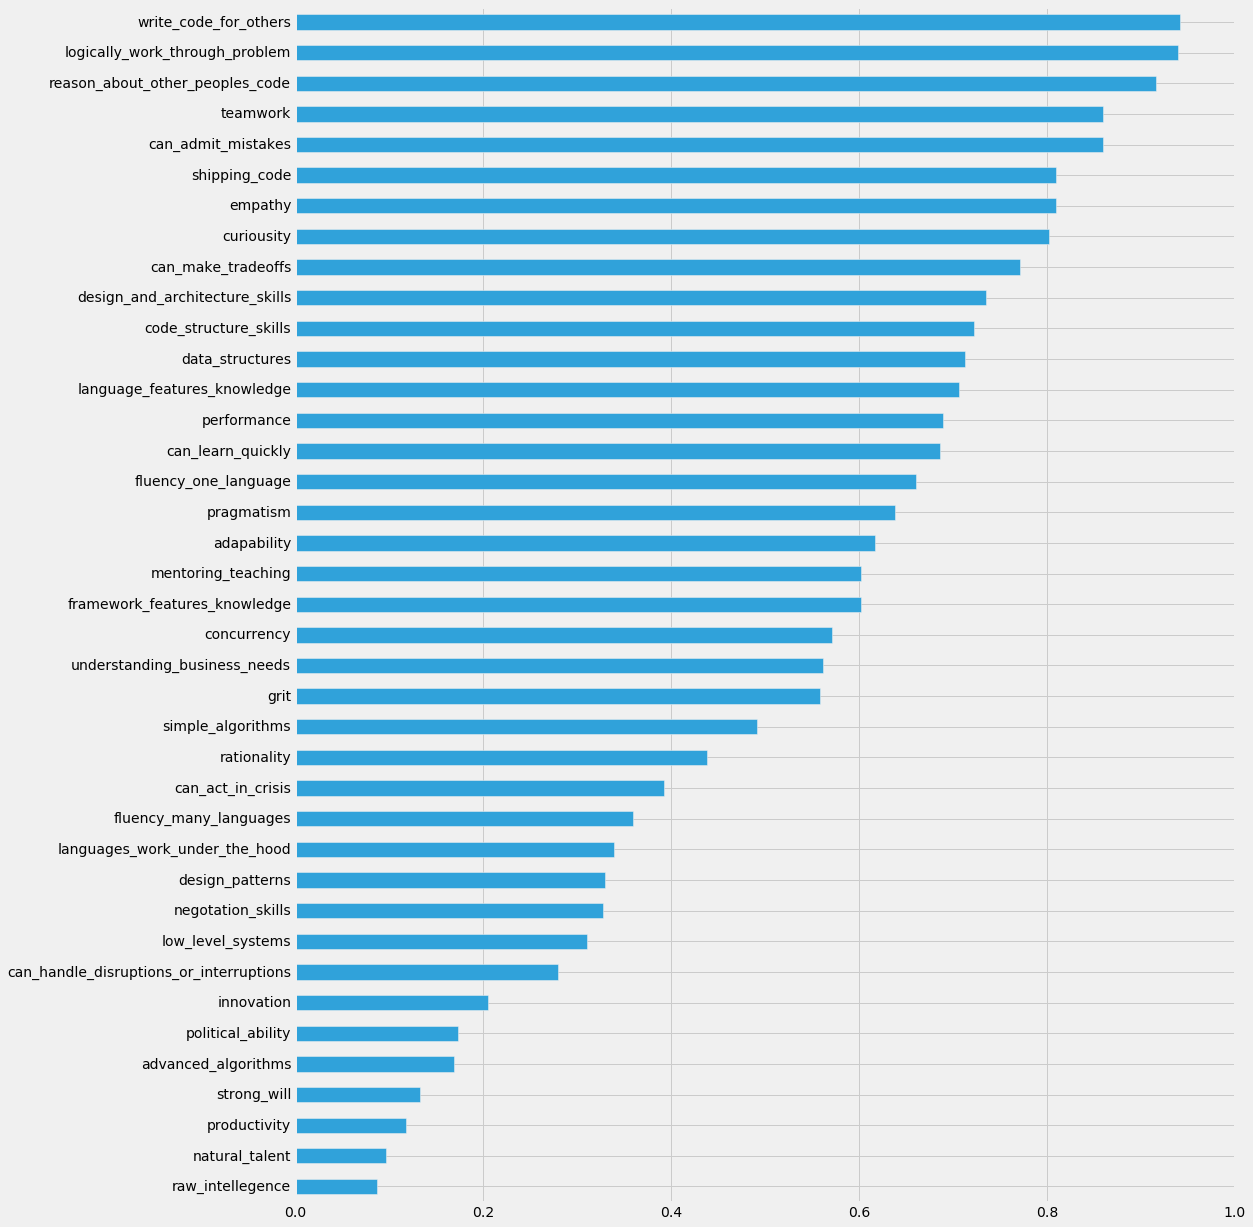

In [107]:
trait_plot3 = age_35_traits_data.stack()[UNDER_THIRTY_FIVE].sort_values(ascending=True).plot(kind='barh')

plt.show()

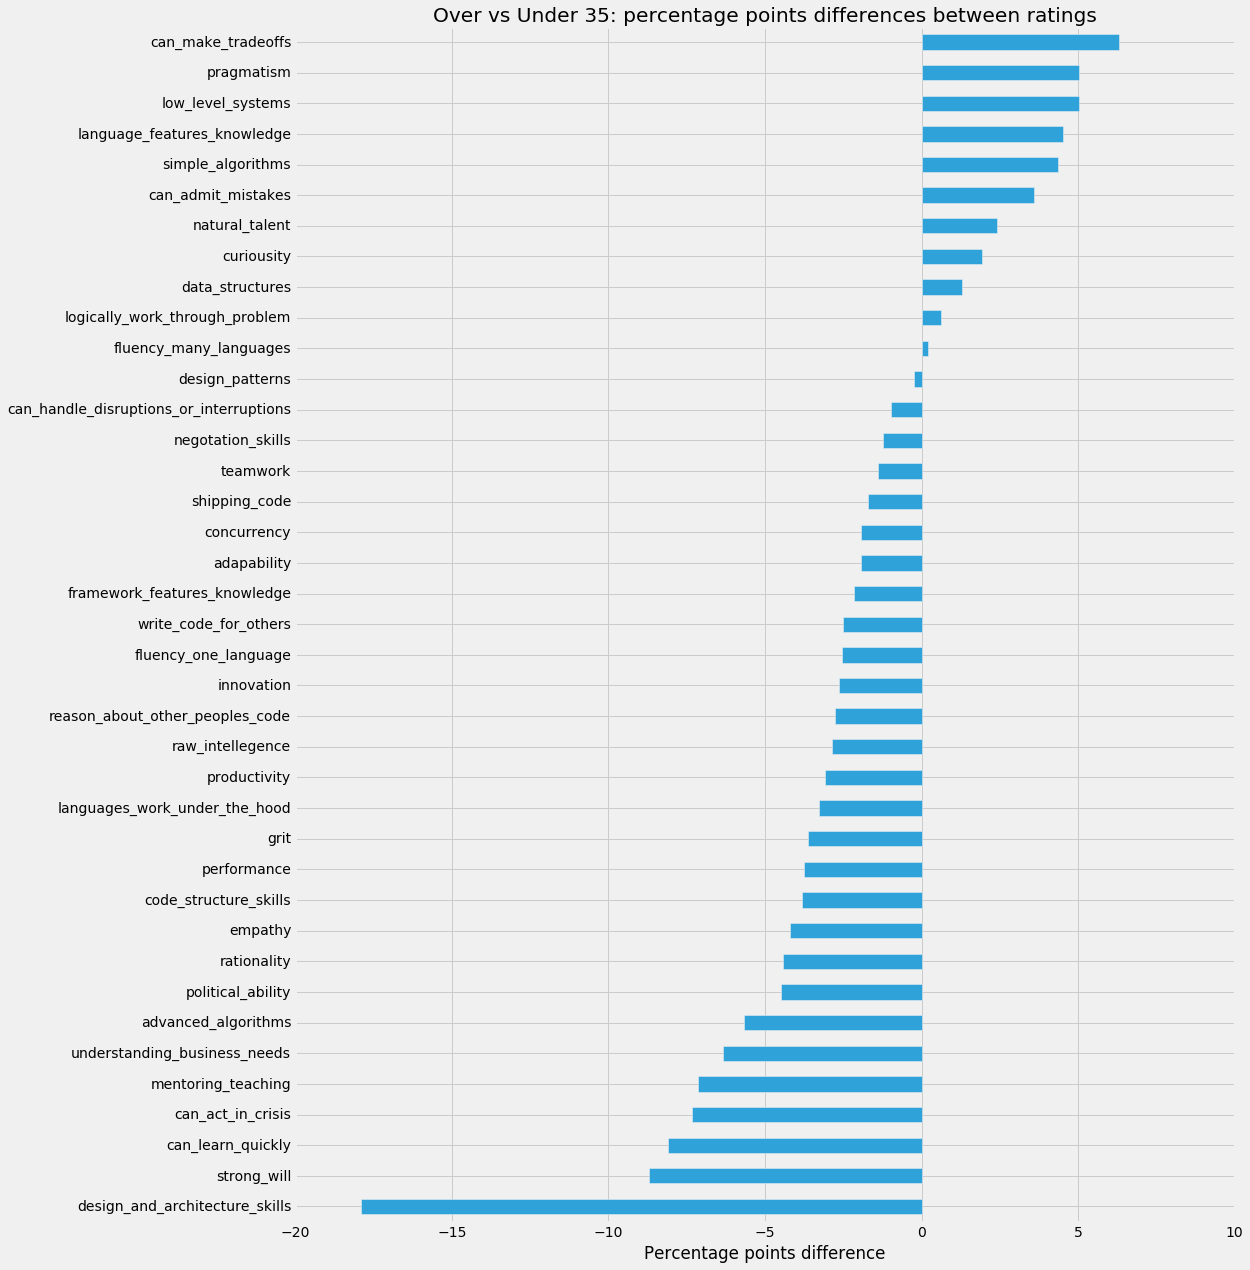

In [115]:
trait_plot = traits_difference_35.sort_values(ascending=True).plot(kind='barh')
trait_plot.set_title('Over vs Under 35: percentage points differences between ratings')
trait_plot.set_xlabel('Percentage points difference')

plt.show()

# Statistical significance

trying out t-test here

In [112]:
olds_eng_group = age_traits_engineers_only_data[age_traits_engineers_only_data['over_35'] == OVER_THIRTY_FIVE]
youngs_eng_group = age_traits_engineers_only_data[age_traits_engineers_only_data['over_35'] == UNDER_THIRTY_FIVE]

ttest_significance = []
for trait in eng_traits:
    result = stats.ttest_ind(olds_eng_group[trait], youngs_eng_group[trait])
    ttest_significance.append({'trait': trait, 'ttest_statistic': result.statistic, 'pvalue': result.pvalue})
    
ttest = pd.DataFrame(ttest_significance, columns=['trait', 'pvalue', 'ttest_statistic'])

The t-test is supposed to show how likely it is the two groups differ by chance, with the standard threshold being 5% (0.05). The correlation to this is 1 in 20 of these is statistically wrong.

In [113]:
ttest[ttest['pvalue'] <= 0.05].sort_values('pvalue')

,trait,pvalue,ttest_statistic
9,design_and_architecture_skills,0.000002,-4.769246
26,strong_will,0.000347,-3.596085
17,can_learn_quickly,0.035308,-2.109188
2,advanced_algorithms,0.048903,-1.973119


In [116]:
traits_by_age_25 = age_25_traits_data.transpose()

traits_by_age_25['Difference'] = (traits_by_age_25[OVER_TWENTY_FIVE] - traits_by_age_25[UNDER_TWENTY_FIVE])
traits_by_age_25.applymap(lambda x: '%.1f%%' % (x * 100))


over_25,No,Yes,Difference
adapability,66.7%,60.4%,-6.3%
advanced_algorithms,19.0%,14.3%,-4.7%
can_act_in_crisis,55.6%,34.6%,-21.0%
can_admit_mistakes,90.5%,87.0%,-3.5%
can_handle_disruptions_or_interruptions,34.9%,26.8%,-8.1%
can_learn_quickly,74.6%,64.8%,-9.8%
can_make_tradeoffs,73.0%,80.1%,7.1%
code_structure_skills,76.2%,70.3%,-5.9%
concurrency,71.4%,54.8%,-16.6%
curiousity,84.1%,80.6%,-3.5%


In [117]:
traits_difference_25 = traits_by_age_25.apply(lambda row: (row[OVER_TWENTY_FIVE] - row[UNDER_TWENTY_FIVE]) * 100,axis=1)


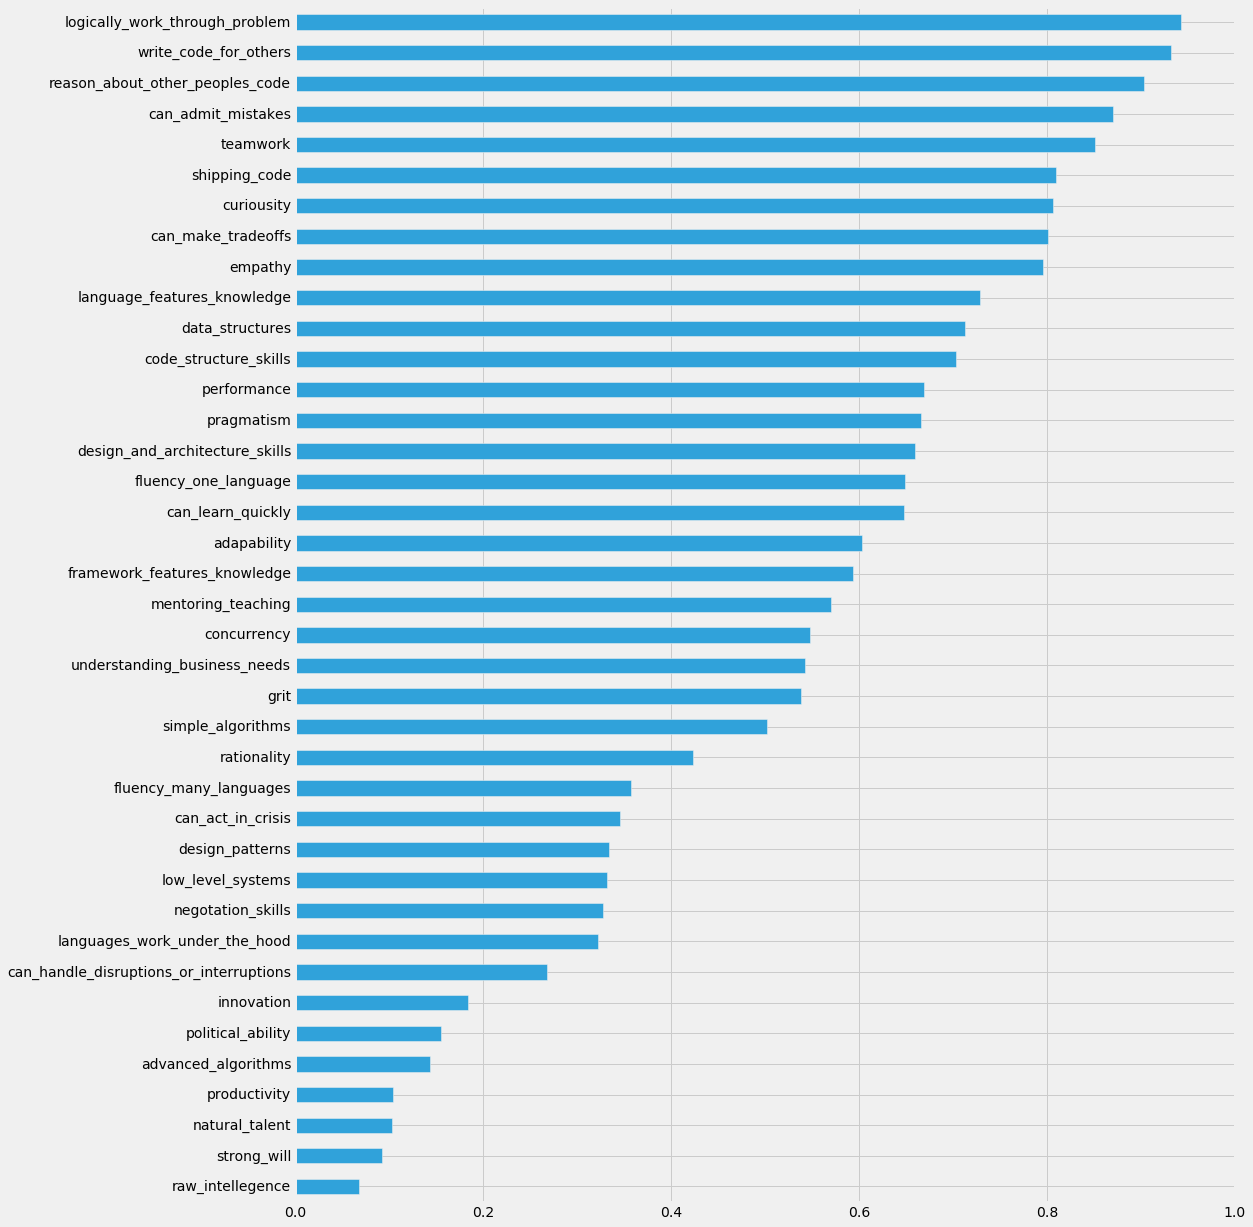

In [118]:
trait_plot4 = age_25_traits_data.stack()[OVER_TWENTY_FIVE].sort_values(ascending=True).plot(kind='barh')

plt.show()

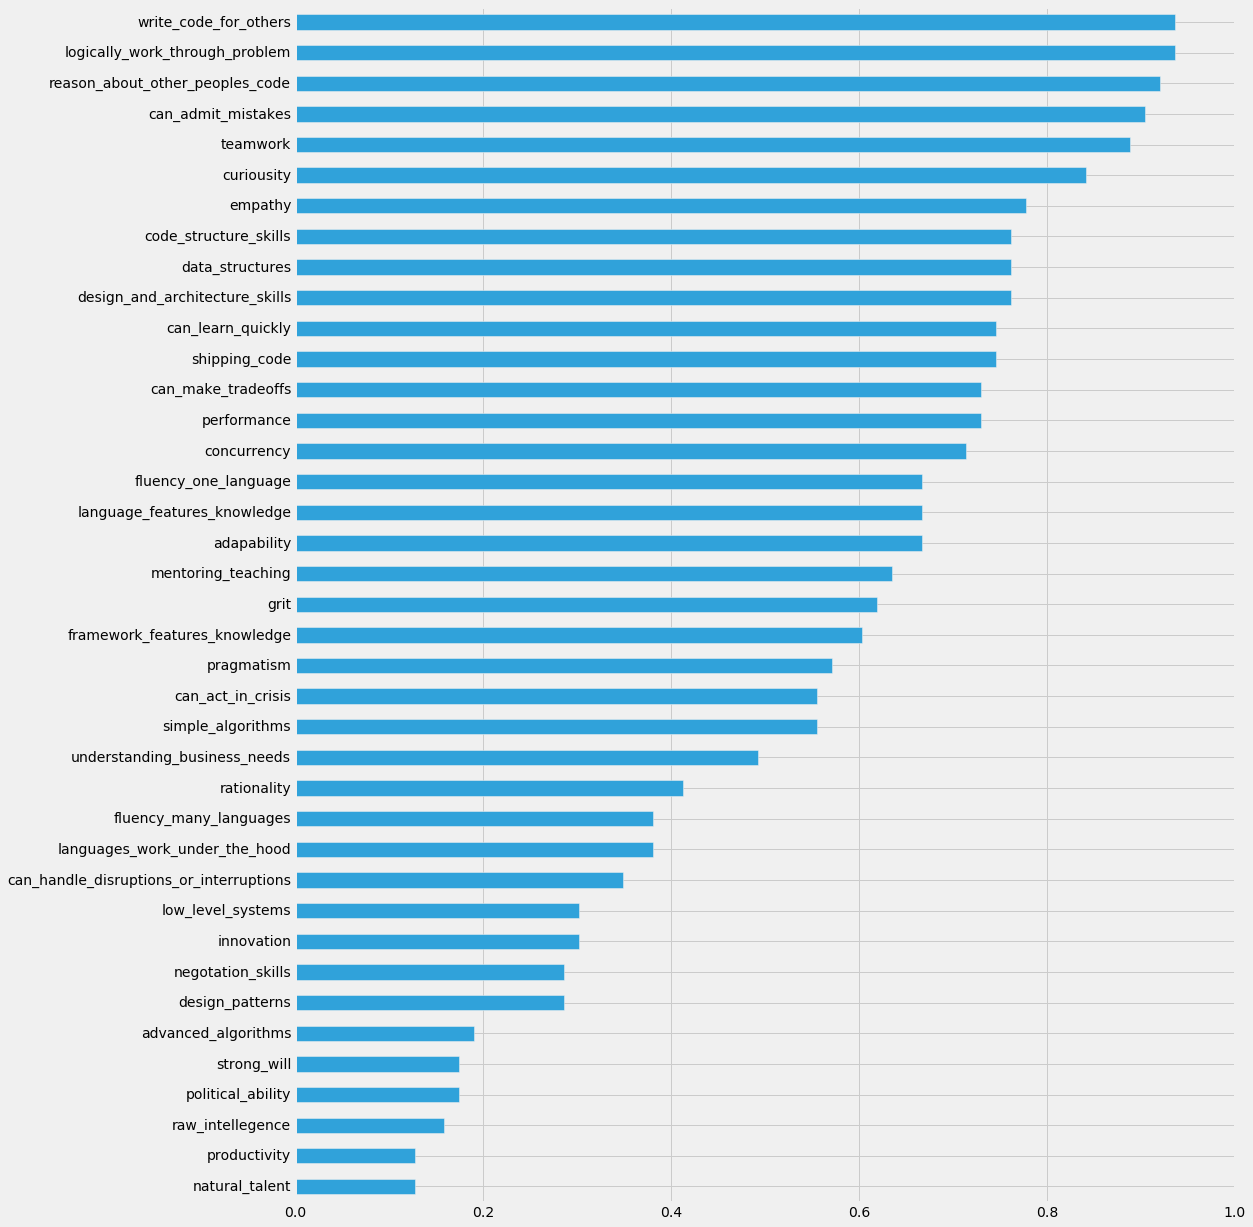

In [119]:
trait_plot5 = age_25_traits_data.stack()[UNDER_TWENTY_FIVE].sort_values(ascending=True).plot(kind='barh')

plt.show()

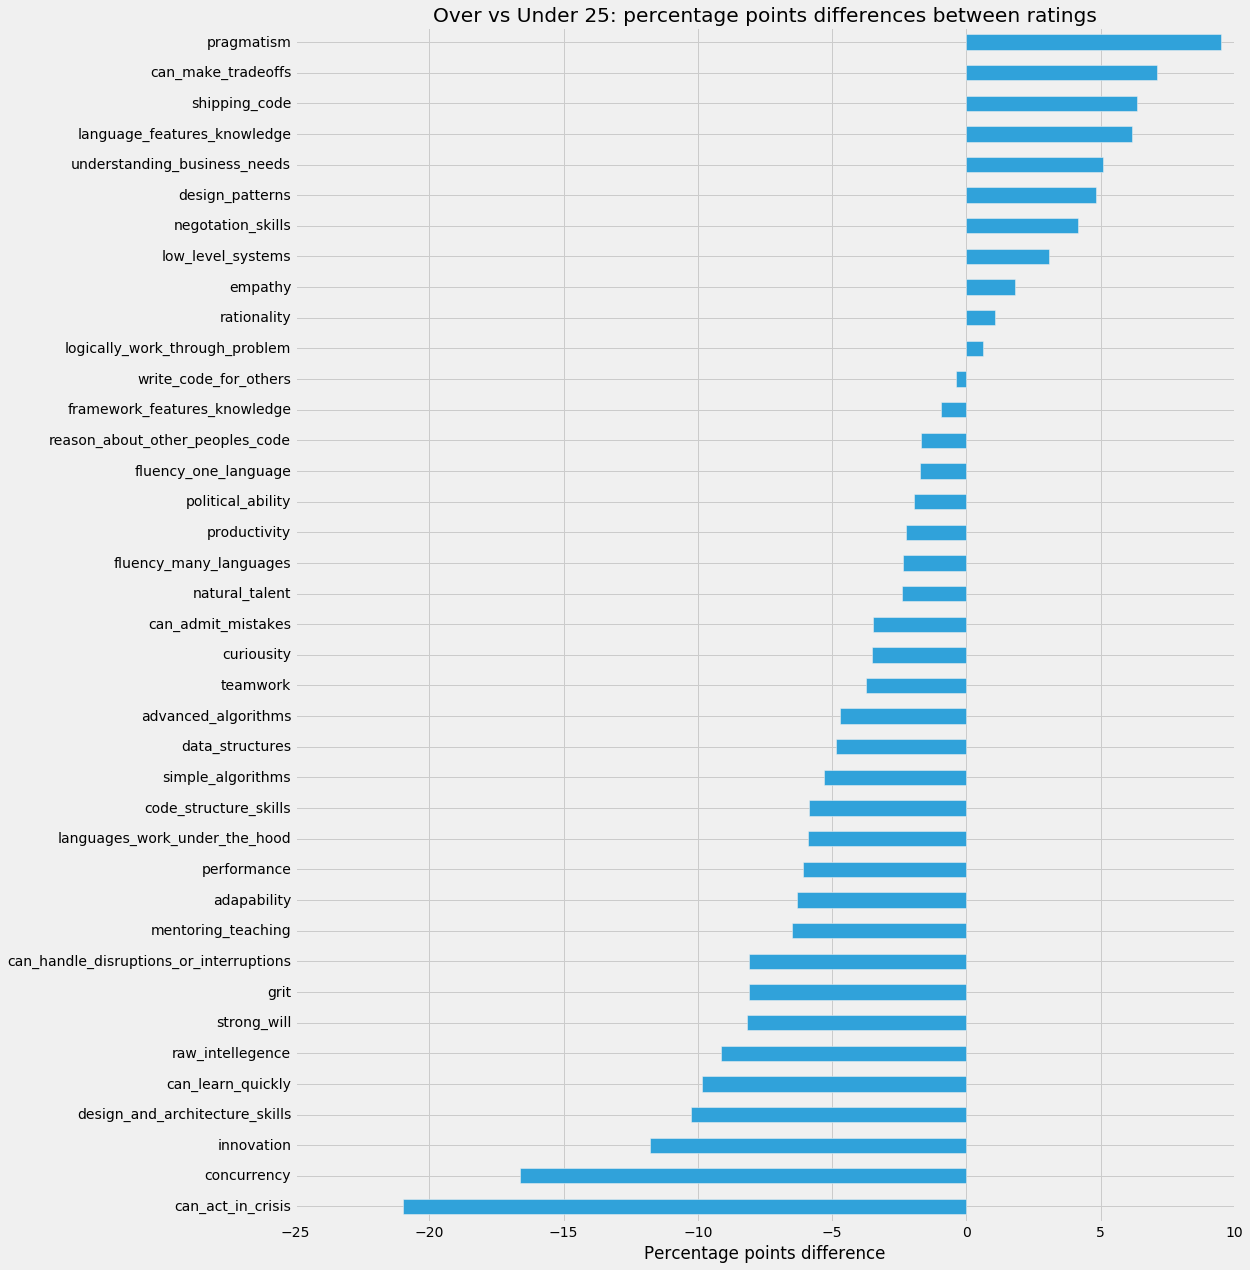

In [120]:
trait_plot2 = traits_difference_25.sort_values(ascending=True).plot(kind='barh')
trait_plot2.set_title('Over vs Under 25: percentage points differences between ratings')
trait_plot2.set_xlabel('Percentage points difference')

plt.show()

# Statistical significance

trying out t-test here

In [121]:
olds_eng_group2 = age_traits_engineers_only_data[age_traits_engineers_only_data['over_25'] == OVER_TWENTY_FIVE]
youngs_eng_group2 = age_traits_engineers_only_data[age_traits_engineers_only_data['over_25'] == UNDER_TWENTY_FIVE]

ttest_significance = []
for trait in eng_traits:
    result = stats.ttest_ind(olds_eng_group2[trait], youngs_eng_group2[trait])
    ttest_significance.append({'trait': trait, 'ttest_statistic': result.statistic, 'pvalue': result.pvalue})
    
ttest = pd.DataFrame(ttest_significance, columns=['trait', 'pvalue', 'ttest_statistic'])

The t-test is supposed to show how likely it is the two groups differ by chance, with the standard threshold being 5% (0.05). The correlation to this is 1 in 20 of these is statistically wrong.

In [122]:
ttest[ttest['pvalue'] <= 0.05].sort_values('pvalue')

,trait,pvalue,ttest_statistic
33,can_act_in_crisis,0.000983,-3.310269
32,raw_intellegence,0.009387,-2.605352
8,concurrency,0.011373,-2.538210
28,innovation,0.024909,-2.247985
26,strong_will,0.040084,-2.056985
